#### A verification of transfer entropy for the Ising model

This Jupyter notebook generates an Ising model and an amended Ising model and extracts the transfer entropy of various sequence in an attempt to recreate the plots of the ork by Razaka and Jensen. 


#### References

1. Razak, Fatimah Abdul, and Henrik Jeldtoft Jensen. "Quantifying ‘causality’in complex systems: understanding transfer entropy." PLoS One 9.6 (2014): e99462.

In [1]:
import numpy as np
from numpy.random import rand,randint
import matplotlib.pyplot as plt
import pandas as pd
from numba import jit
from pyitlib import discrete_random_variable as drv

/home/jithin/anaconda3/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [24]:
L =25
N = L**2
eqsteps = 2000
upvector = np.roll(np.arange(L),-1)
downvector = np.roll(np.arange(L),1)

In [48]:
@jit
def ising_step(states,T):
    beta = 1.0/(T)
    for steps in range(N):
        i = randint(0,L)
        j = randint(0,L)
        E = 2*states[i,j]*(states[i,upvector[j]]+states[i,downvector[j]]+states[upvector[i],j]+states[downvector[i],j])
        if E < 0:
            states[i,j] *= -1
        elif rand() < np.exp(-E*beta):
            states[i,j] *= -1
    return states

@jit
def random_int(L):
    states = 2*randint(2, size=(L,L))-1
    return states


@jit
def amended_ising_step(states,T,state0value):
    beta = 1.0/(T)
    for steps in range(N):
        i = randint(0,L)
        j = randint(0,L)
        if i == L-1:
            if j == L-1:
                if state0value == -1:
                    continue
        E = 2*states[i,j]*(states[i,upvector[j]]+states[i,downvector[j]]+states[upvector[i],j]+states[downvector[i],j])
        if E < 0:
            states[i,j] *= -1
        elif rand() < np.exp(-E*beta):
            states[i,j] *= -1
    return states


In [51]:
#@jit 
def ising(L,T,eqsteps=2000,simsteps =50000):
    states = random_int(L)
    MCstates = np.zeros((L**2,simsteps))
    for eqstep in range(eqsteps):
        states = ising_step(states,T)
    for steps in range(simsteps):
        states = ising_step(states,T)
        MCstates[:,steps] = states.flatten()
    return MCstates


def amended_ising(L,T,eqsteps=2000,simsteps =50000):
    states = random_int(L)
    MCstates = np.zeros((L**2,simsteps))
    state0 = np.zeros(eqsteps+simsteps+11)
    i = 0
    for eqstep in range(10):
        states = ising_step(states,T)
        state0[i] = states[0,0]
        i +=1
    for eqstep in range(eqsteps):
        states = amended_ising_step(states,T,state0[i-10])
        state0[i] = states[0,0]
        i +=1
    for steps in range(simsteps):
        states = amended_ising_step(states,T,state0[i-10])
        state0[i] = states[0,0]
        i +=1
        MCstates[:,steps] = states.flatten()
    return MCstates

In [74]:

def TE(X,X_1,Y):
    '''
    Input:
        Takes times series X, X_1 (Which is X one step before)and Y
    Output:
        ans  - Measure of how 
        Joint Distribution of X,X_1 and Y
        Conditional Distribution of X given X_1
        Conditional Distribution of X given X_1 and Y
    '''
    if len(X) != len(X_1):
        print('Lengths of X and X_1 dont match')
    elif len(X) != len(Y):
        print("Lengths of X and Y dont match")
    m  = [np.random.randint(-10,-5) for i in range(len(X))]
    df = pd.DataFrame({'X':X,'X_1':X_1, 'Y':Y, 'm':m})
    States_X = list(set(X))
    States_X_1 = list(set(X_1))
    States_Y = list(set(Y))
    JointDist = df.groupby(['X', 'X_1','Y']).count()/len(df) 
    JointDist = JointDist.reorder_levels(['X','X_1','Y']).sort_index()
    DistXgivenX_1 = (df.groupby(['X','X_1']).count() / df.groupby(['X_1']).count())
    DistXgivenX_1 =DistXgivenX_1.reorder_levels(['X','X_1']).sort_index()
    
    countto = lambda x: x / x.count()
    DistXgivenX_1Y = df.groupby(['X','X_1','Y']).count().groupby(['X_1','Y']).transform(countto)
                          
    DistXgivenX_1Y = DistXgivenX_1Y.reorder_levels(['X','X_1','Y']).sort_index()
    ans = 0
    for  x in States_X:
        for y in States_Y:
            for z in States_X_1:
                try:
                    #print('Joint Dist :'+ str(JointDist.loc[x,z,y]['m']))
                    #print(' Dist 1 :'+ str(DistXgivenX_1Y.loc[x,z,y]['m']))
                    #print(' Dist 2:'+ str(DistXgivenX_1.loc[x,z]['m']))
                    f = JointDist.loc[x,z,y]['m']*np.log(DistXgivenX_1Y.loc[x,z,y]['m']/DistXgivenX_1.loc[x,z]['m'])
                    #print(f)
                    #print('E:' +str( f))
                    #print(JointDist.loc[x,z,y]['m'],DistXgivenX_1Y.loc[x,z,y]['m'],DistXgivenX_1.loc[x,z]['m'])
                    ans += f
                    #print(ans)
                except:
                    pass
    return ans,JointDist
 

In [52]:
Trange = np.linspace(2,3,11)
TEX_Y = np.zeros(len(Trange))
TEY_X = np.zeros(len(Trange))
TEX_Y_amended = np.zeros(len(Trange))
TEY_X_amended = np.zeros(len(Trange))
i = 0
L=25
for T in Trange:
    MCstates= ising(L,T)
    MCstates[MCstates==-1]=0
    X_1 = MCstates[0,9:-1]
    X = MCstates[0,10:]
    Y = MCstates[-1,:-10]
    TEX_Y[i] = drv.information_mutual_conditional(X,Y,X_1)
    X_1 = MCstates[-1,9:-1]
    X = MCstates[-1,10:]
    Y = MCstates[0,:-10]
    TEY_X[i] = drv.information_mutual_conditional(X,Y,X_1)
    
    MCstates2= amended_ising(L,T)
    MCstates2[MCstates2==-1]=0Hi, Niall,
    X_1 = MCstates2[0,9:-1]
    X = MCstates2[0,10:]
    Y = MCstates2[-1,:-10]
    TEX_Y_amended[i] = drv.information_mutual_conditional(X,Y,X_1)
    X_1 = MCstates2[-1,9:-1]
    X = MCstates2[-1,10:]
    Y = MCstates2[0,:-10]
    TEY_X_amended[i] = drv.information_mutual_conditional(X,Y,X_1)
    i += 1
    print(T)

2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0


##### Regular Ising model.

Each state has some influence on any other state but it should be a symmetric one. We are hence able to recreate Figure 4 in [1] for L =25

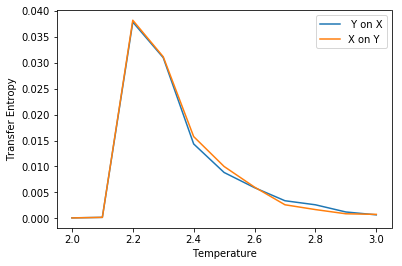

In [57]:
plt.plot(Trange,TEX_Y,label = ' Y on X')
plt.plot(Trange,TEY_X, label = 'X on Y')
plt.xlabel('Temperature')
plt.ylabel('Transfer Entropy')
plt.legend()
#plt.plot(Trange,TEX_Y_amended)Hi, Niall,
#plt.plot(Trange,TEY_X_amended)
plt.show()

#### Amended Ising model

Here, the Ising model is modified that the state at X influences the flip probability at Y but not vice versa. We can thus recreate Figure 10 for L = 25.

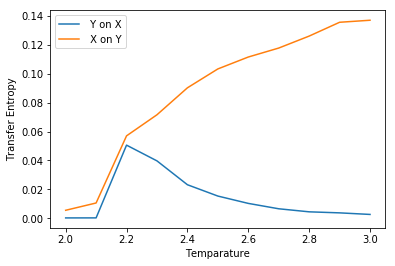

In [58]:
plt.plot(Trange,TEX_Y_amended,label = ' Y on X')
plt.plot(Trange,TEY_X_amended,label = ' X on Y')
plt.xlabel('Temparature')
plt.ylabel('Transfer Entropy')
plt.legend()
plt.show()